In [1]:
import RF_input_parameters as RF_inp
import RF_tile_creator as RF_tc
import RF_tile_classifier as RF_cl

RF_params = RF_inp.RF_Parameters()  # Create base parameters
RF_params.add_tile_creator_params()  # Dynamically add tile creator specific parameters
#RF_tc.create_tiles(RF_params)


Extracting image data from: Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2 - 070923 - Full Run v4\RF_Tiled_Inputs\stacked_bands_tile_input_29.tif
Image extent: 5459 x 9809 (row x col)
Number of Bands: 6
Unique labels values: [1 2 3 4 5 6]
Unique y values: [1 2 3 4 5 6]
Training Random Forest Classifier
OOB prediction of accuracy is: 92.07210304117565%
Model saved to Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2 - 070923 - Full Run v4\RF_Model.joblib
Band 1 importance: 0.1732434936474852
Band 2 importance: 0.19909993976689286
Band 3 importance: 0.09487511712954139
Band 4 importance: 0.25786560998499175
Band 5 importance: 0.18272481811006866
Band 6 importance: 0.09219102136102009
predict      1      2      3       4      5      6     All
truth                                                     
1        84267      0      0       0      0      0   84267
2            0  52622      0       0      0      0   52622
3            0      1  11389       0      0      0   11390

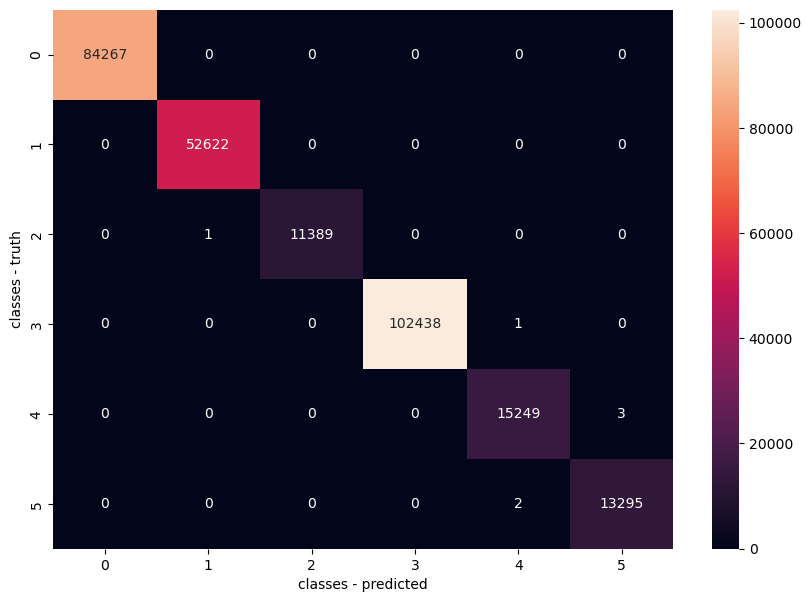

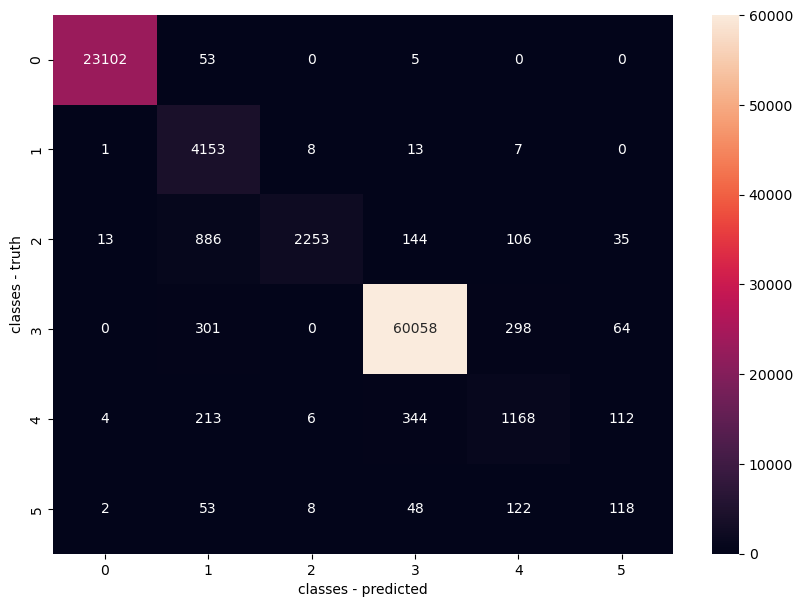

In [2]:
if RF_params.add_classifier_params().model_path is None:
    import RF_trainer as RF_tr
    import RF_input_parameters as RF_inp
    RF_params.add_trainer_params()  # Add training specific parameters
    RF_tr.train_model(RF_params)

In [3]:
import RF_input_parameters as RF_inp

RF_params.add_classifier_params()  # Add classification specific parameters
RF_params.model_path = r" Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2 - 070923 - Full Run v4\RF_Model.joblib"

RF_cl.classify_tiles(RF_params)

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
# from Results_Processing.Mask_Raster_by_Classification import mask_raster_by_classification
# import RF_input_parameters as RF_inp
# import os

# output_fn = os.path.join(RF_params.output_folder, 'Masked_Tiles.tif')
# mask_raster_by_classification( RF_params.classified_tile_paths, RF_params.DEM_path, output_fn, RF_params.BE_values)